# Ejemplo simple de LSTM para adivinar la proxima palabra.

El ejemplo que ilustro enseguida, probablemente no va a funcionar :(  por que parace que los datos que usaba los removieron. Sin embargo, vamos a intentar.

In [1]:
# import libraries
import tensorflow
from tensorflow.keras.preprocessing.text  import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!pwd

/content


In [11]:
!mkdir -p /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
import shutil
shutil.move("kaggle.json", "/root/.kaggle")

'/root/.kaggle'

In [14]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': Not a directory


In [8]:
!ls  -l /root/.kaggle

-rw-r--r-- 1 root root 71 May 15 23:09 /root/.kaggle


In [15]:
!chmod 600 kaggle.json

In [17]:
!kaggle datasets download -d adangonzalez/sherlock-holmes-txt

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adangonzalez/sherlock-holmes-txt")

print("Path to dataset files:", path)

100%|██████████| 221k/221k [00:00<00:00, 79.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/adangonzalez/sherlock-holmes-txt/versions/1


In [19]:
!ls

drive  kaggle.json  sample_data


In [25]:
!cd /root/.cache/kagglehub/datasets

In [26]:
!pwd

/content


In [30]:
!cp -r /root/.cache/kagglehub/datasets/adangonzalez .

In [31]:
!ls

adangonzalez  drive  kaggle.json  sample_data


In [32]:
!cd adangonzalez/

In [33]:
!ls

adangonzalez  drive  kaggle.json  sample_data


In [34]:
!pwd

/content


In [35]:
!ls adangonzalez/sherlock-holmes-txt/

1.complete  versions


In [36]:
!cp /content/adangonzalez/sherlock-holmes-txt/versions/1/Sherlock.txt .

In [37]:
!ls

adangonzalez  drive  kaggle.json  sample_data  Sherlock.txt


In [1]:
file = open("Sherlock.txt", "r")
file

FileNotFoundError: [Errno 2] No such file or directory: 'Sherlock.txt'

In [40]:
lines = []
for i in file:
  lines.append(i)

lines[:10]


['The Adventures of Sherlock Holmes\n',
 '\n',
 'by Arthur Conan Doyle\n',
 '\n',
 '\n',
 'Contents\n',
 '\n',
 '   I.     A Scandal in Bohemia\n',
 '   II.    The Red-Headed League\n',
 '   III.   A Case of Identity\n']

In [41]:
# creamos los datos para procesarlos
data = ""
for i in lines:
  data = ' '. join(lines)

data[:100] #QC

'The Adventures of Sherlock Holmes\n \n by Arthur Conan Doyle\n \n \n Contents\n \n    I.     A Scandal in B'

In [42]:
# process data
data1 = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data1[:100]

'The Adventures of Sherlock Holmes  by Arthur Conan Doyle   Contents     I.     A Scandal in Bohemia '

In [43]:
# removemos espacios multiples usando "split" y "join"
data2 = data1.split()
data2 = ' '.join(data2)
data2[:100]

'The Adventures of Sherlock Holmes by Arthur Conan Doyle Contents I. A Scandal in Bohemia II. The Red'

In [44]:
data2[:1000]

'The Adventures of Sherlock Holmes by Arthur Conan Doyle Contents I. A Scandal in Bohemia II. The Red-Headed League III. A Case of Identity IV. The Boscombe Valley Mystery V. The Five Orange Pips VI. The Man with the Twisted Lip VII. The Adventure of the Blue Carbuncle VIII. The Adventure of the Speckled Band IX. The Adventure of the Engineer’s Thumb X. The Adventure of the Noble Bachelor XI. The Adventure of the Beryl Coronet XII. The Adventure of the Copper Beeches I. A SCANDAL IN BOHEMIA I. To Sherlock Holmes she is always _the_ woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position. He 

In [48]:
# tokenize data
import itertools
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data2])
word_index = tokenizer.word_index
dict(itertools.islice(word_index.items(), 10))

{'the': 1,
 'and': 2,
 'to': 3,
 'of': 4,
 'i': 5,
 'a': 6,
 '”': 7,
 'in': 8,
 'that': 9,
 'it': 10}

In [49]:
sequence_data = tokenizer.texts_to_sequences([data2])[0]
sequence_data[:10]

[1, 1406, 4, 132, 34, 48, 698, 4604, 4605, 1844]

In [50]:
len(sequence_data)

107995

In [51]:
# estadisticas del vocabulario
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8643


In [52]:
# extraigamos secuencias de 4 palabras cada una.
sequence = []
for i in range(3, len(sequence_data)):
  words = sequence_data[i-3:i+1]
  sequence.append(words)

print("The Length of sequence are: ", len(sequence))
sequence[:10]

The Length of sequence are:  107992


[[1, 1406, 4, 132],
 [1406, 4, 132, 34],
 [4, 132, 34, 48],
 [132, 34, 48, 698],
 [34, 48, 698, 4604],
 [48, 698, 4604, 4605],
 [698, 4604, 4605, 1844],
 [4604, 4605, 1844, 5],
 [4605, 1844, 5, 6],
 [1844, 5, 6, 850]]

In [54]:
# define input/output pairs
X = []
y = []

for i in sequence:
    X.append(i[0:3])
    y.append(i[3])

In [55]:
X[:10]

[[1, 1406, 4],
 [1406, 4, 132],
 [4, 132, 34],
 [132, 34, 48],
 [34, 48, 698],
 [48, 698, 4604],
 [698, 4604, 4605],
 [4604, 4605, 1844],
 [4605, 1844, 5],
 [1844, 5, 6]]

In [56]:
y[:10]

[132, 34, 48, 698, 4604, 4605, 1844, 5, 6, 850]

In [57]:
type(X)

list

In [58]:
# convertimos lista en arreglos
X = np.array(X)
y = np.array(y)

# convierto a categorical
y = to_categorical(y, num_classes=vocab_size)
y[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [59]:
len(y[0])

8643

In [60]:
max(y[0])

np.float64(1.0)

In [61]:
np.argmax(y[0])

np.int64(132)

In [62]:
y[0][132]

np.float64(1.0)

In [66]:
# build the LSTM model
nunits = 1000
sequence_length=3
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=10, input_shape=(sequence_length,)))
model.add(LSTM(units=nunits, return_sequences=True))
model.add(LSTM(units=nunits))

model.add(Dense(units=nunits, activation='relu'))
model.add(Dense(units=vocab_size, activation='softmax'))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 3, 10)          │        86,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 3, 1000)        │     4,044,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1000)           │     8,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8643)           │     8,651,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,787,073 (83.11 MB)

 Trainable params: 21,787,073 (83.11 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# entrenamiento del modelo
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))


In [ ]:
# training
model.fit(X, y, epochs=2, batch_size=64, callbacks=[checkpoint])

# Gate Recurrent Units  (GRU).
Estas fueron introducidas por Cho et al., 2014. La idea era usar menos parametros y tener mejor performance.

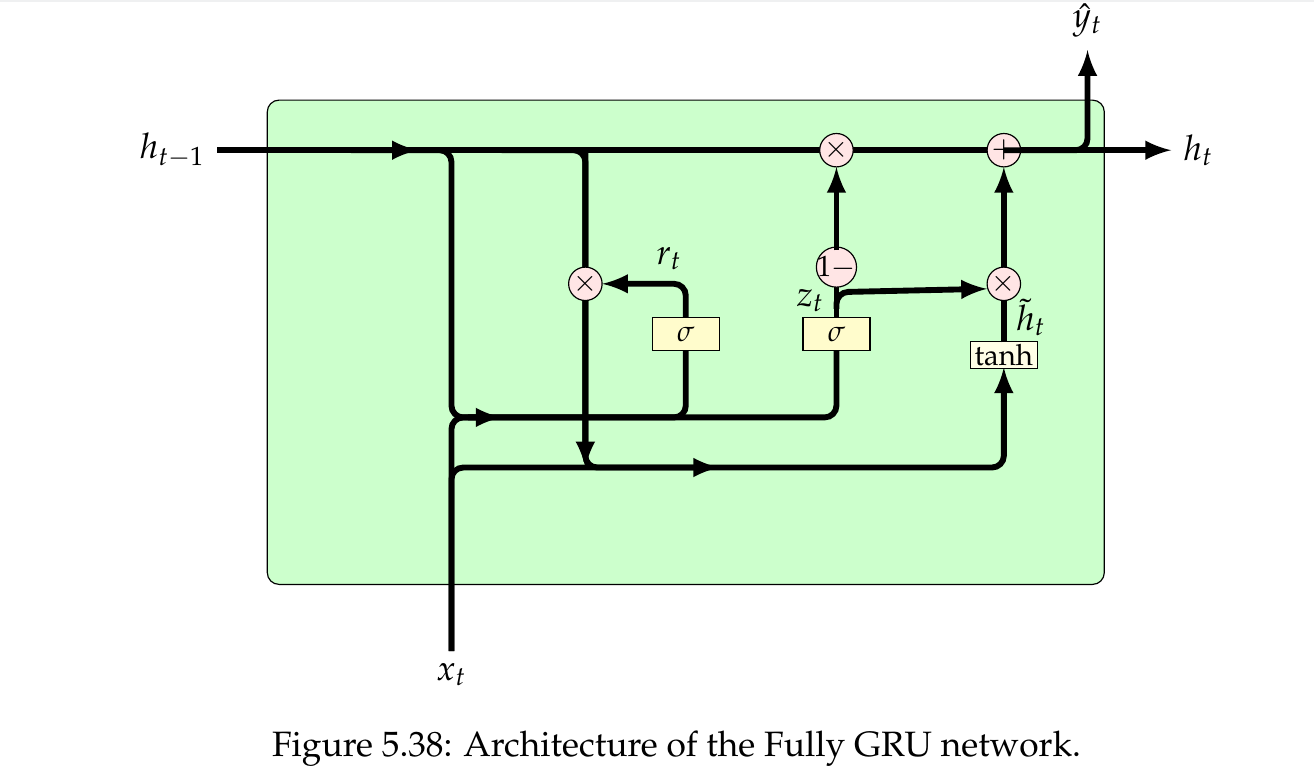

Las ecuaciones asociadas a esta arquitectura son

\begin{eqnarray}
z_t &=& \sigma( W_z x_t + U_z h_{t-1} + b_z) \\
r_t &=& \sigma(W_r x_t + U_r h_{t-1} + b_r) \\
\hat{h}_t &=& \tanh( W_h x_t + U_h r_t \circ h_{t-1} + b_h) ?? \\
h_t &=& (1 - z_t) \circ h_{t-1} + z_t \circ \hat{h}_t.
\end{eqnarray}

# Modelos semi-supervisados, auto-supervisados, y no supervisados.
Aca veremos modelos generativos.

Los metodos de lenguaje son auto-supervisados (self-supervised) en el sentido de que el mismo texto genera las etiquetas. El ejemplo mas claro es el programa que escribimos arriba. Un ejemplo. Se tiene las siguientte secuencia de palabras

" the wheather today is very ____".
Aca caben muchas posibilidades "cold, warm, nice, hot, humid".

En lo que sigue vamos a estudiar, auto-encoders y las GAN, con el objeto de

* **reduccion de dimensionalidad**
* **eliminacion de ruido**
* **generacion de nuevos datos**.

Para la generacion de datos vamos a estudiar las siguientes arquitecturas.

* Variational Autoencoders (VAE).
* Generative Adversarial Networks (GAN).
* Transformers.

## Autoencoders.
Autoencoders son ANN no supervisadas (self-supervised). Son dos redes concectadas. Una se llama "encoder" y la otra "decoder".
La idea es comprimir los datos a un espacio que se llama **latent space** (espacio latente). Comprime los datos. Luego de comprimidos el "decoder" trata de recuperar los datos iniciales. Puden ser

* Redes densas (fully connected , MLP)
* Puen ser redes RNN, LSTM, para datos sequence-to-sequence (traducciones), musica, texto.

* CNN: Se pueden generar imagenes. Vamos a ver mas adelante como los VAN: Variataional autoencoders sirven para generar nuevas imagenes.
Los Transformers usan encoders y decoders.





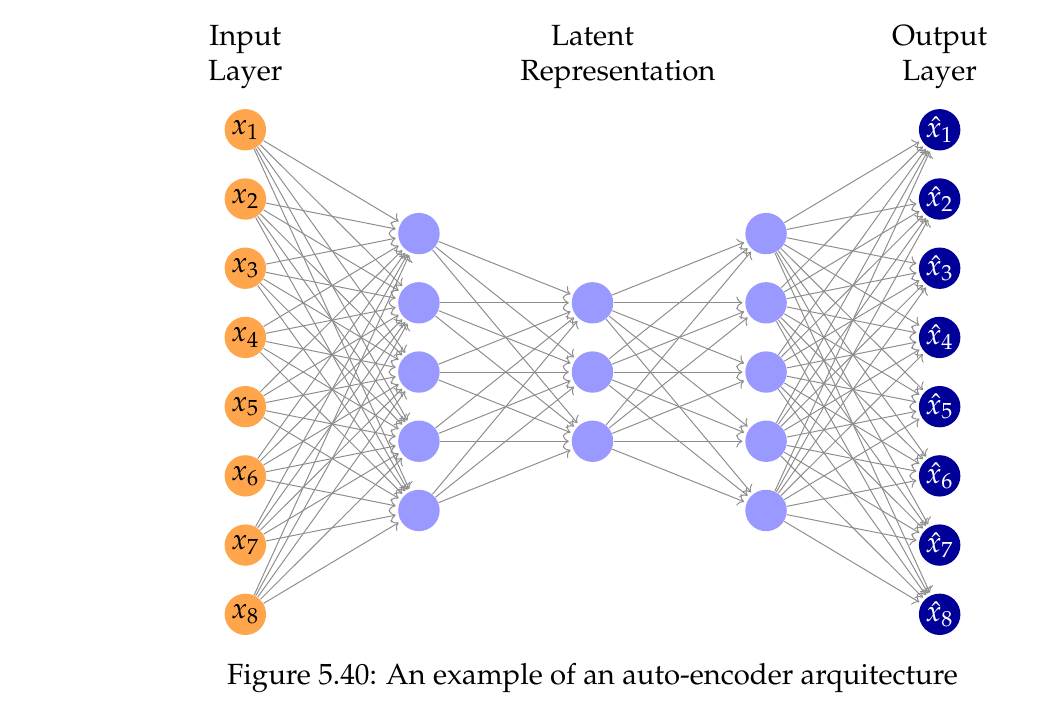

La arquitectura de aca es del tipo MLP: Va de muchos nodos a pocos de forma gradual hasta alcanzar el "cuello de botella" (latent space) y luego comienza a crecer nuevamente en nodos hasta alcanzar el numero de nodos originales.

Si usaramos convolucion tenemos la siguiente arquitectura

* Encoder: Convolucion + activacion + bach normalization + pooling. (esto reduce).

* Decoder: convolucion transpuesta (transpose convolution) + activacion + batch normalization.


El modelo matematico para construir la funcion de costo.
Los datos $x$ se comprimen mediante una funcion $f=f(x)$. Una vez comprimida llega otra funcion $g$ que hace el papel de descompresion. La idea es que

$$g(f(x)) = \hat{x} = r(x) .  $$

La funcion de costo esta definida por

$$J(\theta) = \| x - \hat{x} \| + \lambda R(x). $$
Rifai et al., define el contractive autencoders usando la siguiente funcion de regularizacion

$$R(x) = \lambda \left \|  \frac{\partial f}{\partial x}  \right \|_F^2 $$
Esta funcion de regularizacion le pone un penalti a rugosidad y entonces beneficia soluciones suaves.

Algunas aplicaciones de autoencoders son

* Reduccion de dimensionalidad (esta clase)
* modelos generativos (VAC) (proxima clase)
* denosing (eliminacion de ruido, proxima clase)
* deteccion de anomalias (no lo vemos nosotros).

### Reduccion de dimensionalidad con auto-encoders.
En la Figura 5.40 vemos que el espacio de entrada se reduce de
$\mathbb{R}^8$ a $\mathbb{R}^3$.

Nos preguntamos si el AE (AautoEncoders) hace el mismo papel que PCA en la reduccion de la dimensionalidad. Si el modelo es lineal si. Pero el PCA es puramente lineal, en cambio los AE van mas alla de lo lineal.

Veamos un ejemplo del sentido de la reduccion de dimensionalidad.
Piense en una recta en un espacio de $10^6$ de dimensiones. Sigue siendo una recta. Por ejemplo dados dos puntos $P,Q \in \mathbb{R}^{10^6}$ la funcion

\begin{eqnarray}
L_{PQ} : \mathbb{R} &\to& \mathbb{R}^{10^6} \\
t &\to& L_{PQ}(t) = P + t (Q- P)
\end{eqnarray}

Realmente la recta es una variedad (manifold) de dimension 1.
La recta es lineal y un PCA le puede extraer la informacion a los puntos de esta recta.

Otro ejemplo no lineal, es la helix (helice). Una ecuacion parametrica de una helice es  $(\cos t, \sin t , t )$. Tambien es una variedad (manifold) de una dimension. Tome la recta y la "enrolla" como un resorte. Aca estamos en 3 dimensiones


\begin{eqnarray}
H : \mathbb{R} &\to& \mathbb{R}^{3} \\
t &\to& H(t) = (\cos t, \sin t , t)
\end{eqnarray}

La Figura 5.41 ilustra estas curvas.


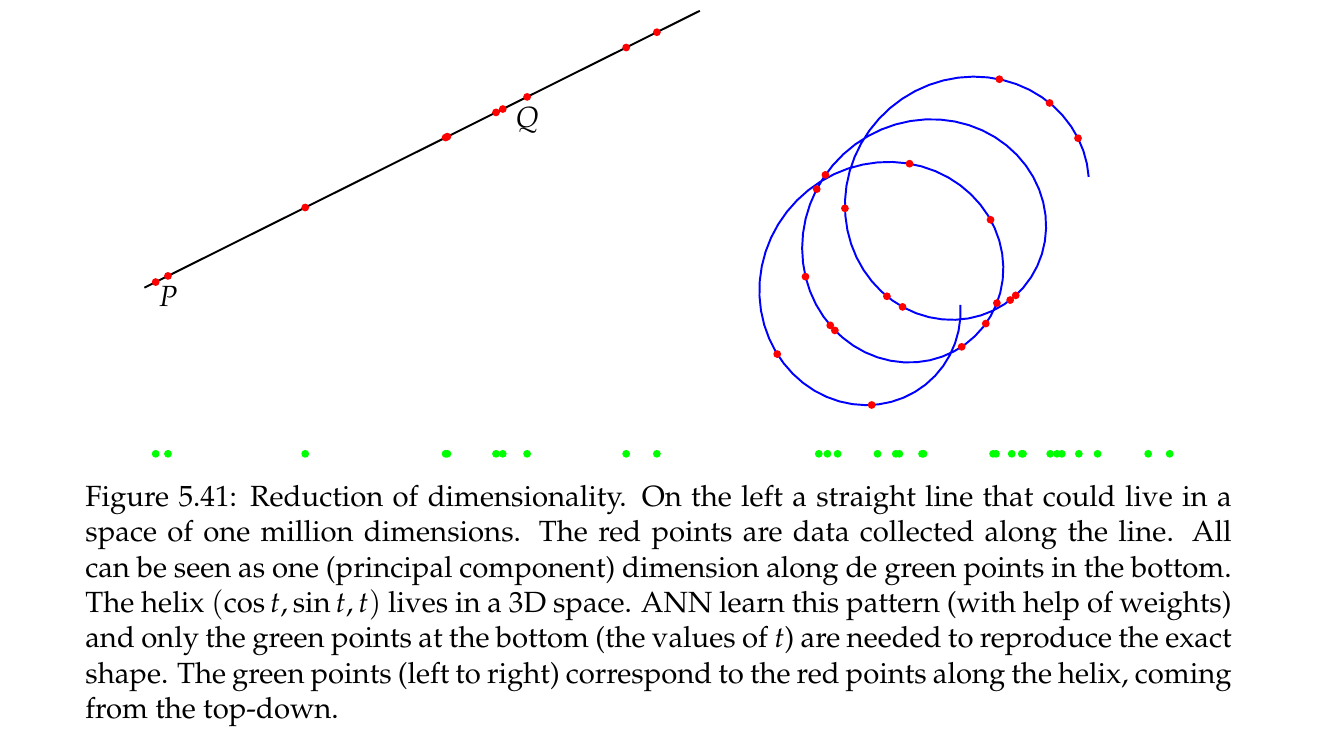

La reduccion de dimensionalidad se da gracias a la correlacion entre los datos. Si los datos no tienen niguna correlacion (ruido blanco) es imposible tumbar dimensiones sin perder informacion.

Tambien, en vez de curvas puedes pensar en superficies y estas son variedades (manifolds) de dimension 0. Por ejemplo $f(x,y)=x^2 + y^2$.
Asi sucesivamente para manifolds de cualquier dimension.

Al final, si puedes comprimir tus datos a la mayor rata posible, estas hablando de la **dimension intrinseca**. (**intrinsic dimension**).
La dimension intrinsica es el menor numero de variables que necesitas para expresar tus datos sin ninguna perdida.

Veamos varios ejemplos en `Python`.

In [2]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers  import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

In [4]:
# load the mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape the data to 28, 28, 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# define the dimensions
input_shape = (28, 28, 1)
encoding_dim = 32 # este es el tamanho del cuello de botella.

# define the autoencoder model
input_img = Input(shape=input_shape)
x = Flatten()(input_img)
encoded = Dense(encoding_dim, activation='relu')(x)
decoded = Dense(np.prod(input_shape), activation='sigmoid')(encoded)
decoded = Reshape(input_shape)(decoded)

# construct the autoencoder
autoencoder = Model(input_img, decoded)

# construct the encoder model
encoder = Model(input_img, encoded)

# compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3808 - val_loss: 0.1897
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1802 - val_loss: 0.1525
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1482 - val_loss: 0.1330
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1306 - val_loss: 0.1211
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1200 - val_loss: 0.1129
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1124 - val_loss: 0.1070
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1072 - val_loss: 0.1026
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1028 - val_loss: 0.0992
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0999 - val_loss: 0.0969
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0976 - val_loss: 0.0951
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0961 - val_loss: 0.0941
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


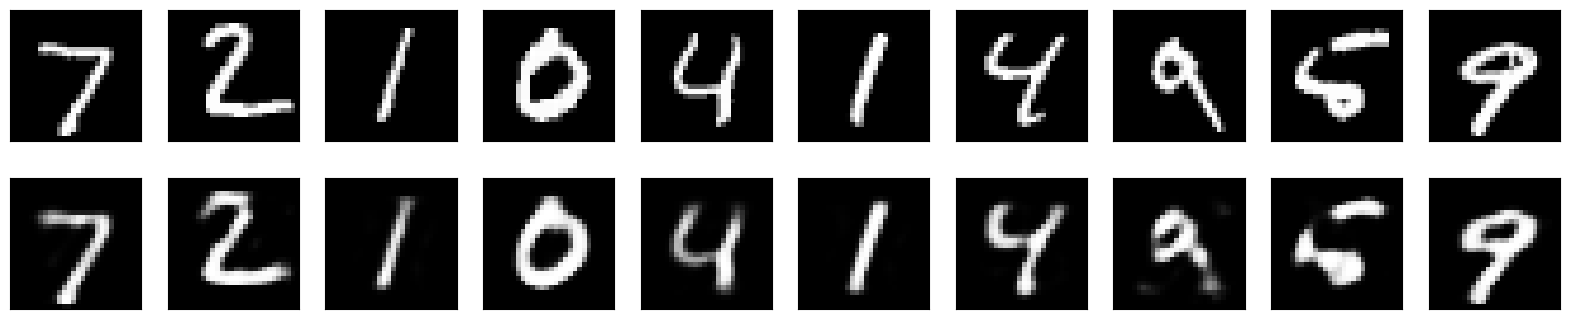

Encoded representations of the first 10 test images
[[ 6.5176315  13.501361    3.5851827  10.124773    7.225925    9.015972
   9.532902    7.3881683  12.07663     2.520136    2.976461    1.8304472
   1.2800393   4.2117367  10.066224   10.546076    4.4822483   3.4567318
   2.3509612   5.1738634   7.3179145   5.938702    8.709096    3.4779356
   1.7989979   7.8603225  10.087663    4.626902    6.517357    8.318562
   6.5042043   4.332761  ]
 [ 0.5869796   6.1155457   8.73505    15.352732    9.28701    15.924626
  12.473352    2.5070236   4.179641    4.3668246   6.398034    2.5122004
   5.540486    9.15392     0.57423425 10.566119    7.962886   20.988108
   2.4994712  11.154059    3.3081226   8.136636    5.5189257  13.855481
  14.674807    7.1852546   6.421912   13.876448    6.0094023   6.644568
   3.0495462   8.338565  ]
 [ 0.          4.231326    4.561533    5.0801816   2.8690262   5.3513317
   2.1202717   5.603605    5.65369     7.674815    4.9211073   3.3654547
   5.518012    3.6277041

In [5]:
# usemos el encoder para probar
encoded_imgs = encoder.predict(x_test)

# display 10 imagenes originales y sus respectivas reconstrucciones.
n=10
plt.figure(figsize=(20,4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstructed images
    ax = plt.subplot(2, n, i+1+n)
    decoded_imgs = autoencoder.predict(x_test)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# mostramos algunos numeros en 32 dimensiones.
print("Encoded representations of the first 10 test images")
print(encoded_imgs[0:10])

Vamos a ver otra forma en que los autoencoders ayudan en la reduccion de dimensionalidad y vamos a comparar con el trabajo que hace PCA.

In [6]:
# veamos el analisis de PCA en el MNIST data set
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



<function matplotlib.pyplot.show(close=None, block=None)>

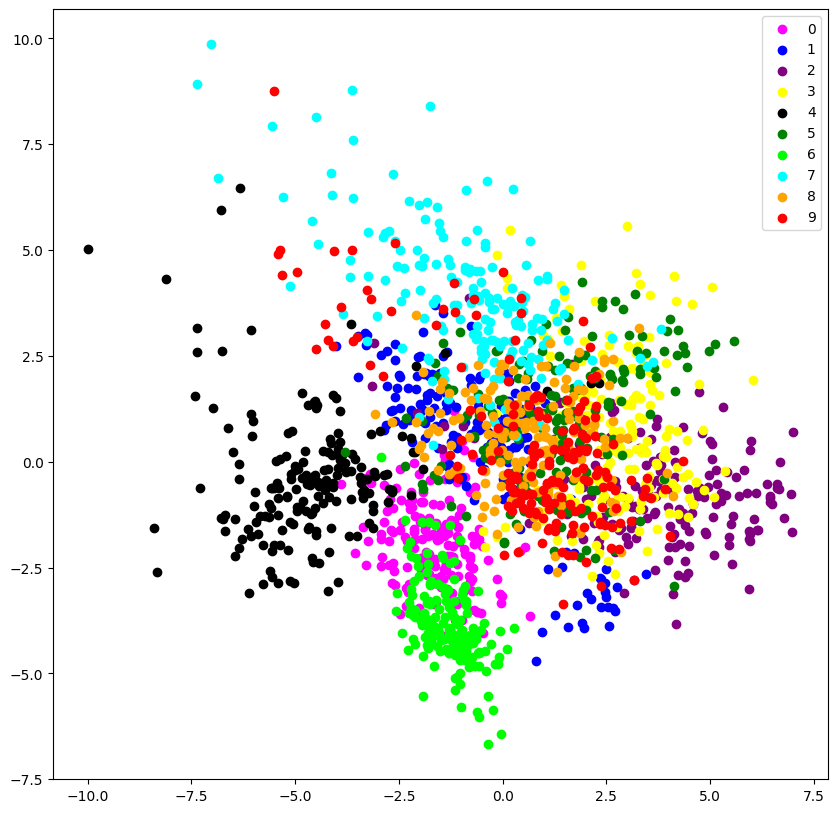

In [7]:
# load de MNIST
digits = datasets.load_digits()
data = digits.data
target = digits.target

# estandarizacion de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# apply PCA to reduce to 2 dimensiones.
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# create scatter plot
plt.figure(figsize=(10,10))

colors=['magenta', 'blue', 'purple', 'yellow', 'black', 'green', 'lime', 'cyan', 'orange', 'red']

for i in range(len(colors)):
    px = data_pca[:,0][target == i]
    py = data_pca[:,1][target == i]
    plt.scatter(px, py, c=colors[i], label=digits.target_names[i])

plt.legend()
plt.show

Hagamos el mismo ejercicio con los AE.

In [8]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers  import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

In [12]:
from enum import auto
# load the mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255.
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.astype('float32')/255.
x_test = x_test.reshape((x_test.shape[0],-1))


# define the dimensions
input_shape = (784,)
encoding_dim=2
intermediatte_dim = 128
batch_size = 256
epochs = 50

# encoder model
input_img = Input(shape=input_shape)
encoded = Dense(intermediatte_dim, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# decoder model
decoder_h = Dense(intermediatte_dim, activation='relu')
decoder_mean = Dense(input_shape[0], activation='sigmoid')
h_decoded = decoder_h(encoded)
decoded_mean = decoder_mean(h_decoded)

# construct the autoencoder
autoencoder = Model(input_img, decoded_mean)
encoder = Model(input_img, encoded)

# compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

# encode the test data
x_tes_encoded = encoder.predict(x_test, batch_size=batch_size)


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.3733 - val_loss: 0.2386
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2371 - val_loss: 0.2270
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2264 - val_loss: 0.2199
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.2195 - val_loss: 0.2156
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.2162 - val_loss: 0.2120
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.2115 - val_loss: 0.2094
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.2091 - val_loss: 0.2078
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.2074 - val_loss: 0.2067
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.2060 - val_loss: 0.2057
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2050 - val_loss: 0.2045
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2040 - val_loss: 0.2038
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━

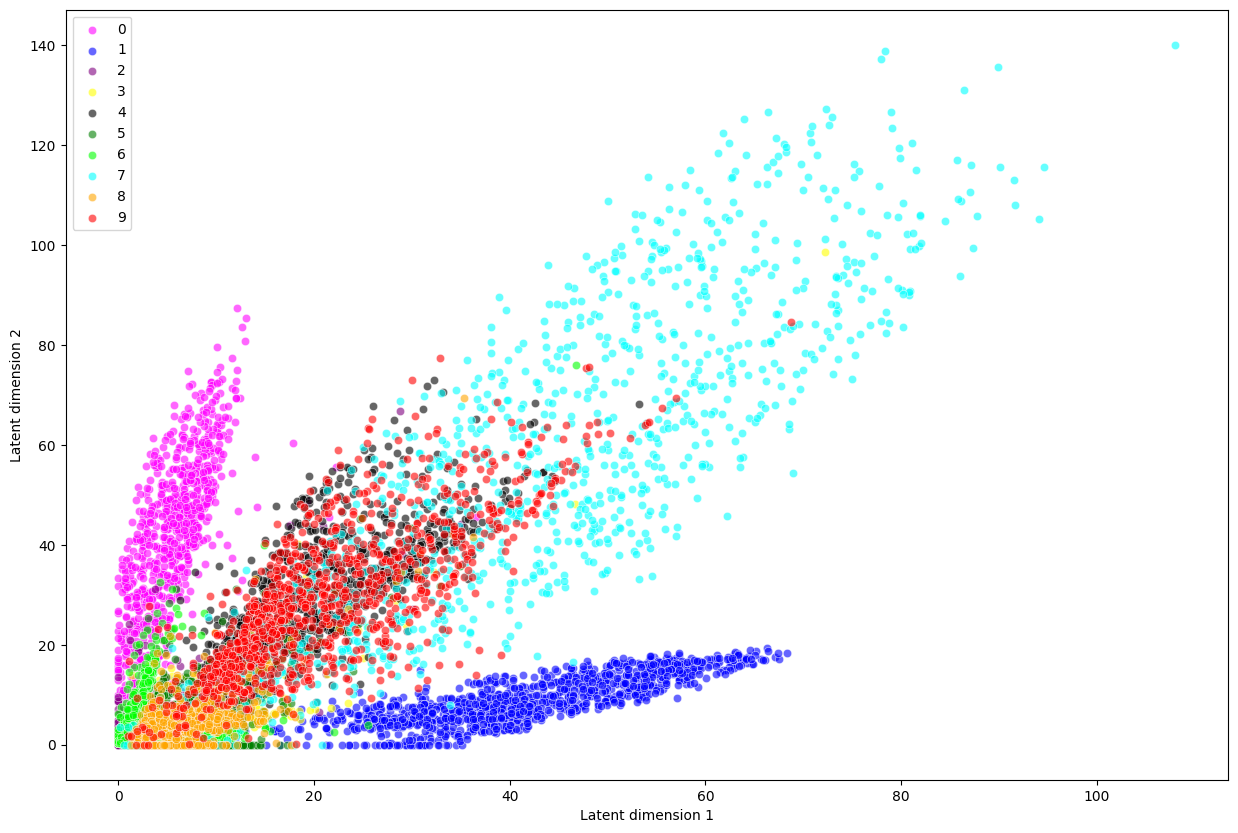

In [16]:
# do the scatter plot
plt.figure(figsize=(15,10))
colors=['magenta', 'blue', 'purple', 'yellow', 'black', 'green', 'lime', 'cyan', 'orange', 'red']
for i in range(len(colors)):
    plt.scatter(x_tes_encoded[y_test == i, 0], x_tes_encoded[y_test == i, 1], c=colors[i], label=digits.target_names[i], alpha=0.6,
                edgecolors='w', linewidth=0.5)
plt.legend()
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.show()
